# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **religious events or traditions** (see below) for the region of **Ann Arbor, Michigan, United States**, or **United States** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **Ann Arbor, Michigan, United States** to Ann Arbor, USA. In that case at least one source file must be about **Ann Arbor, Michigan, United States**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **Ann Arbor, Michigan, United States** and **religious events or traditions**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **religious events or traditions**?  For this category you might consider calendar events, demographic data about religion in the region and neighboring regions, participation in religious events, or how religious events relate to political events, social movements, or historical events.

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together for the **Ann Arbor, MI, USA** area using **sports and athletics** as the topic. [Example Solution File](./readonly/Assignment4_example.pdf)

In [1]:
# Data Source: CRIME Data Michigan
# https://s3-us-gov-west-1.amazonaws.com/cg-d4b776d0-d898-4153-90c8-8336f86bdfec/2019/MI-2019.zip

# Holiday data:
# https://www.calendar-12.com/calendar/2019


In [2]:
import re
from urllib.request import urlopen
import numpy as np
import lxml.html as lh
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook



In [3]:
# Using religious events/holidays calendar from link below
year = "2019"
link = "https://www.calendar-12.com/calendar/"+year
response = urlopen(link)
content = response.read().decode("utf-8")

def find_table( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

table = find_table(content, '<div class="year-calendar-holidays">',"/div><!-- #holidays_list -->");

doc = lh.fromstring(table)
tr_elements = doc.xpath('//tr')

col=[]
i=0

for t in tr_elements:
    i+=1
    name=t.text_content()
    col.append((name,[]))

re_pattern = '\s+([0-9]{1,2} \w+)\s+'
c = re.compile(re_pattern)
dates_list = [c.findall(x[0]) for x in col]

# make it flat as findall generates list of lists
dates_list = [year + ' '+x for dates_inlist in dates_list for x in dates_inlist]

# dates_list
df_dates = pd.DataFrame(dates_list, columns=['Date'])
df_dates['Date'] = pd.to_datetime(df_dates['Date'],format = '%Y %d %B')
df_dates['RELIGIOUS'] = 1
df_dates['DATE_TYPE'] = 'RELIGIOUS'
df_dates.head()
# df_dates.size

Date  RELIGIOUS  DATE_TYPE
0 2019-01-01          1  RELIGIOUS
1 2019-05-30          1  RELIGIOUS
2 2019-01-06          1  RELIGIOUS
3 2019-06-09          1  RELIGIOUS
4 2019-01-21          1  RELIGIOUS

In [4]:
# Reading INCIDENTS
inc = pd.read_csv('NIBRS_incident.csv')
inc['INCIDENT_DATE'] = pd.to_datetime(inc['INCIDENT_DATE'])
# inc['SUBMISSION_DATE'] = pd.to_datetime(inc['SUBMISSION_DATE'])
inc = inc[['INCIDENT_ID','INCIDENT_DATE','INCIDENT_HOUR']]
inc.head()

INCIDENT_ID INCIDENT_DATE  INCIDENT_HOUR
0    114203967    2019-02-25           11.0
1    114208094    2019-07-07            3.0
2    114204215    2019-05-09           21.0
3    114204798    2019-06-12           19.0
4    114208640    2019-06-14            6.0

In [5]:
# Reading OFFENDER data
offender = pd.read_csv('NIBRS_OFFENDER.csv')

# Read OFFENCE_TYPE
offense_type = pd.read_csv('NIBRS_OFFENSE_TYPE.csv')

# Reading OFFENSE data
offense = pd.read_csv('NIBRS_OFFENSE.csv')

x = offense.merge(offense_type)
x = x.merge(offender)

# Merge INCIDENTS with freshly created OFFENSES to find only Person-Person type of incidents
off_new = x[['INCIDENT_ID','SEX_CODE', 'CRIME_AGAINST','OFFENSE_NAME','AGE_NUM','AGE_ID']]
inc = inc.merge(off_new)


In [6]:
# Merge Religious calendar dates to incidents dataframe
inc_df = inc.merge(df_dates, left_on='INCIDENT_DATE', right_on='Date', how='outer')

# Keep only some columns that are later needed
inc_df = inc_df[['INCIDENT_DATE','DATE_TYPE','INCIDENT_HOUR','SEX_CODE','AGE_NUM','AGE_ID']]
# Remove NaN on AGE_NUM
inc_df = inc_df[inc_df['AGE_NUM']>0]

# Fill DATE_TYPE with REGULAR where it's not mapped from dates_df with RELIFIOUS
inc_df['DATE_TYPE'] = inc_df['DATE_TYPE'].apply(lambda x: x if x=='RELIGIOUS' else 'REGULAR')

# Turn AGE_NUM column to INTEGER
inc_df['AGE_NUM'] = inc_df['AGE_NUM'].astype(int)
inc_df.head()

INCIDENT_DATE DATE_TYPE  INCIDENT_HOUR SEX_CODE  AGE_NUM  AGE_ID
0    2019-02-25   REGULAR           11.0        F       36     5.0
2    2019-02-25   REGULAR           16.0        M       31     5.0
3    2019-02-25   REGULAR           22.0        M       35     5.0
4    2019-02-25   REGULAR           19.0        F       18     5.0
5    2019-02-25   REGULAR           10.0        F       36     5.0

In [7]:
# Creates age groups size of 20 (bins or buckets with size of 20)
def age_groups(df, col):
    df['AGE_GROUP'] = df[col].apply(lambda x: '20' if x<21 else ('40' if x<41 else ('60' if x<61 else ('80' if x<81 else '100'))))
    
    return df

In [8]:
def calc_day_count(num, date_type):
    if date_type == 'REGULAR':
        val = 365-df_dates.size
    else:
        val = df_dates.size
    return num/val

In [9]:
# Create new Dataframe wich contains AGE_GROUPS
df = age_groups(inc_df, 'AGE_NUM')
df = df.pivot_table(index=['INCIDENT_DATE','INCIDENT_HOUR','SEX_CODE','AGE_GROUP','DATE_TYPE'],aggfunc='count')
df.reset_index(inplace=True)

df['COUNT'] = df['AGE_ID']
df.drop(['AGE_ID','AGE_NUM'], axis=1, inplace=True)

df['INCIDENT_HOUR'].astype(int)

# Remove data where offender sex is unknown just for keeping clarity
final_df = df[~(df['SEX_CODE']=='U')]
final_df.head()



INCIDENT_DATE  INCIDENT_HOUR SEX_CODE AGE_GROUP  DATE_TYPE  COUNT
0    2019-01-01            0.0        F        20  RELIGIOUS      4
1    2019-01-01            0.0        F        40  RELIGIOUS     23
2    2019-01-01            0.0        F        60  RELIGIOUS      6
3    2019-01-01            0.0        F        80  RELIGIOUS      1
4    2019-01-01            0.0        M       100  RELIGIOUS      1

In [10]:
sns.set_theme(color_codes=True)

<IPython.core.display.Javascript object>


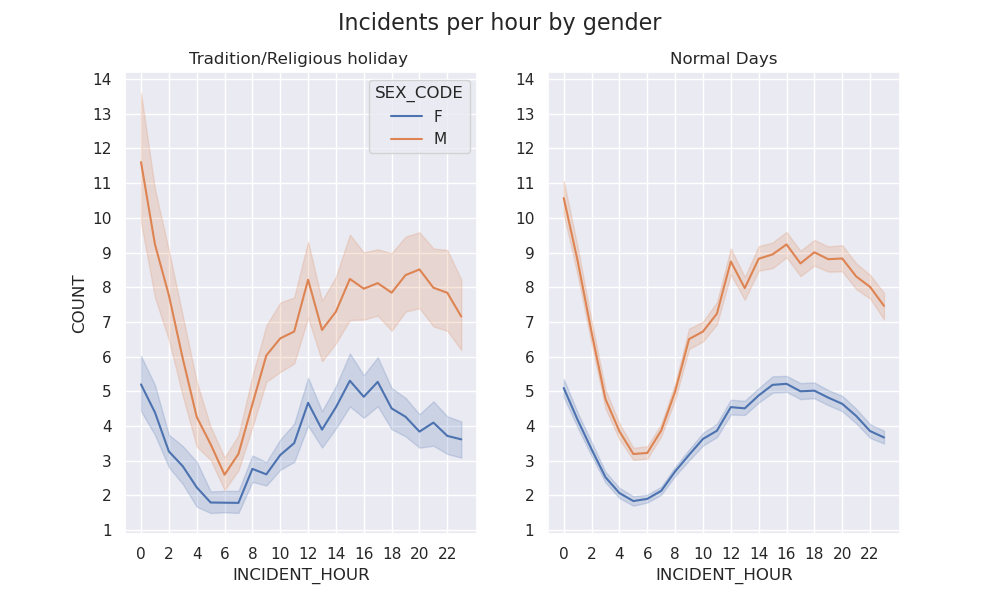

Text(0, 0.5, '')

In [11]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Incidents per hour by gender', fontsize=16)
plt.title('Incidents per hour')
ax1 = plt.subplot(121)

g1 = sns.lineplot(
    data=final_df[final_df['DATE_TYPE']=='RELIGIOUS'],
    x="INCIDENT_HOUR",
    y="COUNT",
    hue='SEX_CODE', legend="brief"
    ).set_title('Tradition/Religious holiday ')

ax2 = plt.subplot(122, sharey=ax1)
g2 = sns.lineplot(
    data=final_df[final_df['DATE_TYPE']=='REGULAR'],
    x="INCIDENT_HOUR",
    y="COUNT",
    hue='SEX_CODE', legend=False
    ).set_title('Normal Days')

ax1.set_yticks(np.arange(1,15,1))
ax1.set_xticks(np.arange(0,24,2))
ax2.set_xticks(np.arange(0,24,2))
# ax2.set_visible(False)
ax2.set_ylabel('')

